# **IPL DATA ANALYSIS**
## **Player-wise Analysis**

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.offline as pyo
import plotly.express as px
import joblib
import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
deliveries_all = joblib.load('deliveries_all.joblib')
matches = joblib.load('matches.joblib')
deliveries = joblib.load('deliveries.joblib')

In [4]:
matches = (
    matches
    .assign(
        winner = lambda df_: df_['winner'].fillna('No Result')
    )
    .replace({'Elimination Final': 'Eliminator'})
)

In [5]:
df_all1 = (
    matches
    .merge(deliveries, left_on = 'id', right_on = 'match_id', how = 'inner') 
)

## 1. Overall Batsman Stats

### 1.1. Batsman Team(s) for Seasons

In [6]:
batsman_striker_list = set(list(deliveries['batter'].unique()))
batsman_non_striker_list = set(list(deliveries['non_striker'].unique()))
non_striker_batter = list(batsman_non_striker_list - batsman_striker_list)
non_striker_batter = pd.DataFrame(non_striker_batter, columns = ['batter'])

In [7]:
def player_teams(player_name):
    if player_name not in non_striker_batter['batter'].values:
        df = (
            df_all1
            .groupby(by = ['batter', 'batting_team', 'season'], as_index = False)
            .agg(count = ('batting_team', 'nunique'))
            .query(f"batter == '{player_name}'")
            .groupby(by = 'batting_team', as_index = False)
            .agg(seasons = ('season', lambda x: ", ".join(x.unique())), count = ('season', lambda x: len((x.unique()))))
            .rename(columns = {'batting_team': 'Team', 'seasons': 'Season', 'count': 'Count'})
        )
    else:
        df = (
            df_all1[df_all1['non_striker'].isin(non_striker_batter['batter'])][['non_striker', 'season', 'batting_team']]
            .groupby(by = ['batting_team'], as_index = False)
            .agg(seasons = ('season', lambda x: ", ".join(x.unique())), count = ('season', lambda x: len((x.unique()))))
            .rename(columns = {'batting_team': 'Team', 'seasons': 'Season', 'count': 'Count'})
        )
    return df

In [8]:
player_teams('AM Rahane')

,Team,Season,Count
0,Chennai Super Kings,"2023, 2024",2
1,Delhi Capitals,"2020, 2021",2
2,Kolkata Knight Riders,2022,1
3,Mumbai Indians,"2008, 2009",2
4,Rajasthan Royals,"2011, 2012, 2013, 2014, 2015, 2018, 2019",7
5,Rising Pune Supergiants,"2016, 2017",2


### 1.2. Overall Stats

In [9]:
def player_century(player_name):
    return (
        df_all1.query(f"batter == '{player_name}'")
        .groupby(by = ['id', 'season', 'bowling_team', 'batter'], as_index = False)
        .agg(Runs = ('batsman_runs', 'sum'))
        .query("Runs >= 100")
        .rename(columns = {'id':'Match ID', 'season': 'Season', 'bowling_team':'Bowling Team', 'batter': 'Batsman'})
    )

In [10]:
player_century('V Kohli')

,Match ID,Season,Bowling Team,Batsman,Runs
119,980937,2016,Gujarat Titans,V Kohli,100
122,980969,2016,Rising Pune Supergiants,V Kohli,108
125,980987,2016,Gujarat Titans,V Kohli,109
127,980999,2016,Kings XI Punjab,V Kohli,113
163,1178410,2019,Kolkata Knight Riders,V Kohli,100
227,1359539,2023,Sunrisers Hyderabad,V Kohli,100
228,1359544,2023,Gujarat Titans,V Kohli,101
233,1422137,2024,Rajasthan Royals,V Kohli,113


In [11]:
def player_half_century(player_name):
    return (
        df_all1.query(f"batter == '{player_name}'")
        .groupby(by = ['id', 'season', 'bowling_team', 'batter'], as_index = False)
        .agg(Runs = ('batsman_runs', 'sum'))
        .query("Runs >= 50 & Runs < 100")
        .rename(columns = {'id':'Match ID', 'season': 'Season', 'bowling_team':'Bowling Team', 'batter': 'Batsman'})
    )

In [12]:
player_half_century('V Kohli').sample(5)

,Match ID,Season,Bowling Team,Batsman,Runs
126,980995,2016,Kolkata Knight Riders,V Kohli,75
131,1082602,2017,Mumbai Indians,V Kohli,62
159,1175372,2019,Kolkata Knight Riders,V Kohli,84
196,1254108,2021,Mumbai Indians,V Kohli,51
79,598045,2013,Kings XI Punjab,V Kohli,57


In [13]:
runs_df = (
    deliveries
    .groupby(by = ['batter'], as_index = False)
    .agg(
        Runs = ('batsman_runs', 'sum'),
        Balls = ('batsman_runs', 'count'),
        Sixes = ('batsman_runs', lambda x: (x == 6).sum()),
        Fours = ('batsman_runs', lambda x: (x == 4).sum()),
        Threes = ('batsman_runs', lambda x: (x == 3).sum()),
        Twos = ('batsman_runs', lambda x: (x == 2).sum()),
        Ones = ('batsman_runs', lambda x: (x == 1).sum()),
        Dots = ('batsman_runs', lambda x: (x == 0).sum())
    )
)

dismissals_df = (
    deliveries
    .groupby(by = ['player_dismissed'], as_index = False)
    .agg(dismissals = ('is_wicket', 'sum'))
)

innings_df = (
    deliveries
    .groupby(by = ['batter'], as_index = False)
    .agg(innings = ('match_id', 'nunique'))
)

batsman_striker_list = set(list(deliveries['batter'].unique()))
batsman_non_striker_list = set(list(deliveries['non_striker'].unique()))
non_striker_batter = list(batsman_non_striker_list - batsman_striker_list)
non_striker_batter = pd.DataFrame(non_striker_batter, columns = ['batter'])

batsman_overall_df = (
    runs_df
    .merge(non_striker_batter, on  = ['batter'], how = 'outer')
    .merge(dismissals_df, left_on = ['batter'], right_on = ['player_dismissed'], how = 'outer')
    .merge(innings_df, on = ['batter'], how = 'outer')
    .sort_values(by = 'Runs', ascending = False, ignore_index = True)
    .assign(
        Runs = lambda df_: df_['Runs'].fillna(0).astype('int'),
        Balls = lambda df_: df_['Balls'].fillna(0).astype('int'),
        Sixes = lambda df_: df_['Sixes'].fillna(0).astype('int'),
        Fours = lambda df_: df_['Fours'].fillna(0).astype('int'),
        Threes = lambda df_: df_['Threes'].fillna(0).astype('int'),
        Twos = lambda df_: df_['Twos'].fillna(0).astype('int'),
        Ones = lambda df_: df_['Ones'].fillna(0).astype('int'),
        dismissals = lambda df_: df_['dismissals'].fillna(0).astype('int'),
        innings = lambda df_: df_['innings'].fillna(1).astype('int'),
        not_outs = lambda df_: df_['innings'] - df_['dismissals'],
        strike_rate = lambda df_: round((df_['Runs']/df_['Balls'])*100, 2),
        batting_average = lambda df_: round(df_['Runs']/df_['dismissals'],2),
        boundary_proportion_of_total = lambda df_: round(((df_['Sixes']*6 + df_['Fours']*4)/df_['Runs'])*100, 2),
        dot_ball_percent = lambda df_: round((df_['Dots']/df_['Balls'])*100,2),
        Dots = lambda df_: df_['Dots'].fillna(0).astype('int')
    )
    .rename(columns = {'batter': 'Batsman', 'dismissals': 'Dismissals', 'innings': 'Innings',
                       'not_outs': 'Not Outs', 'strike_rate': 'Strike Rate', 'batting_average': 'Batting Average', 
                       'boundary_proportion_of_total': 'Boundary Dominance', 'dot_ball_percent': 'Dot Ball Reliance'})
    .drop(columns = 'player_dismissed')
)

In [14]:
batsman_overall_df

,Batsman,Runs,Balls,Sixes,Fours,Threes,Twos,Ones,Dots,Dismissals,Innings,Not Outs,Strike Rate,Batting Average,Boundary Dominance,Dot Ball Reliance
0,V Kohli,8004,6232,273,706,21,445,2589,2198,207,244,37,128.43,38.67,55.75,35.27
1,S Dhawan,6769,5481,153,768,23,299,2102,2134,193,221,28,123.50,35.07,58.95,38.93
2,RG Sharma,6628,5180,281,599,7,263,1994,2035,223,251,28,127.95,29.72,61.59,39.29
3,DA Warner,6565,4844,236,663,24,370,1680,1870,162,184,22,135.53,40.52,61.96,38.60
4,SK Raina,5528,4174,203,506,11,270,1708,1475,170,200,30,132.44,32.52,58.65,35.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
672,KM Asif,0,2,0,0,0,0,0,2,1,1,0,0.00,0.00,NaN,100.00
673,A Nel,0,0,0,0,0,0,0,0,1,1,0,NaN,0.00,NaN,NaN
674,BW Hilfenhaus,0,0,0,0,0,0,0,0,0,1,1,NaN,NaN,NaN,NaN
675,C Ganapathy,0,0,0,0,0,0,0,0,0,1,1,NaN,NaN,NaN,NaN


In [15]:
runs_df1 = (
    df_all1
    .groupby(by = ['season','batter'], as_index = False)
    .agg(
        Runs = ('batsman_runs', 'sum'),
        Balls = ('batsman_runs', 'count'),
        Sixes = ('batsman_runs', lambda x: (x == 6).sum()),
        Fours = ('batsman_runs', lambda x: (x == 4).sum()),
        Threes = ('batsman_runs', lambda x: (x == 3).sum()),
        Twos = ('batsman_runs', lambda x: (x == 2).sum()),
        Ones = ('batsman_runs', lambda x: (x == 1).sum()),
        Dots = ('batsman_runs', lambda x: (x == 0).sum())
    )
)

dismissals_df1 = (
    df_all1
    .groupby(by = ['season', 'player_dismissed'], as_index = False)
    .agg(dismissals = ('is_wicket', 'sum'))
)

innings_df1 = (
    df_all1
    .groupby(by = ['season', 'batter'], as_index = False)
    .agg(innings = ('match_id', 'nunique'))
)

batsman_striker_list = set(list(df_all1['batter'].unique()))
batsman_non_striker_list = set(list(df_all1['non_striker'].unique()))
non_striker_batter = list(batsman_non_striker_list - batsman_striker_list)
non_striker_batter = pd.DataFrame(non_striker_batter, columns = ['batter'])
non_striker_batter_df = df_all1[df_all1['non_striker'].isin(non_striker_batter['batter'])][['non_striker', 'season']]
non_striker_batter_df = non_striker_batter_df.rename(columns = {'non_striker': 'batter'})

batsman_overall_df1 = (
    runs_df1
    .merge(non_striker_batter_df, on  = ['season','batter'], how = 'outer')
    .merge(dismissals_df1, left_on = ['season','batter'], right_on = ['season','player_dismissed'], how = 'outer')
    .merge(innings_df1, on = ['season','batter'], how = 'outer')
    .sort_values(by = 'season', ignore_index = True)
    .assign(
        Runs = lambda df_: df_['Runs'].fillna(0).astype('int'),
        Balls = lambda df_: df_['Balls'].fillna(0).astype('int'),
        Sixes = lambda df_: df_['Sixes'].fillna(0).astype('int'),
        Fours = lambda df_: df_['Fours'].fillna(0).astype('int'),
        Threes = lambda df_: df_['Threes'].fillna(0).astype('int'),
        Twos = lambda df_: df_['Twos'].fillna(0).astype('int'),
        Ones = lambda df_: df_['Ones'].fillna(0).astype('int'),
        dismissals = lambda df_: df_['dismissals'].fillna(0).astype('int'),
        innings = lambda df_: df_['innings'].fillna(1).astype('int'),
        not_outs = lambda df_: df_['innings'] - df_['dismissals'],
        strike_rate = lambda df_: round((df_['Runs']/df_['Balls'])*100, 2),
        batting_average = lambda df_: round(df_['Runs']/df_['dismissals'],2),
        boundary_proportion_of_total = lambda df_: round(((df_['Sixes']*6 + df_['Fours']*4)/df_['Runs'])*100, 2),
        dot_ball_percent = lambda df_: round((df_['Dots']/df_['Balls'])*100,2)
    )
    .rename(columns = {'season': 'Season', 'batter': 'Batsman', 'dismissals': 'Dismissals', 'innings': 'Innings',
                       'not_outs': 'Not Outs', 'strike_rate': 'Strike Rate', 'batting_average': 'Batting Average', 
                       'boundary_proportion_of_total': 'Boundary Dominance', 'dot_ball_percent': 'Dot Ball Reliance'})
    .drop(columns = 'player_dismissed')
    [['Season', 'Batsman', 'Innings', 'Runs', 'Balls', 'Sixes', 'Fours', 'Threes', 'Twos', 'Ones', 'Dots',	
      'Dismissals', 'Not Outs', 'Strike Rate',	'Batting Average', 'Boundary Dominance', 'Dot Ball Reliance']]
)

In [16]:
batsman_overall_df1[batsman_overall_df1['Batsman'] == 'V Kohli']

,Season,Batsman,Innings,Runs,Balls,Sixes,Fours,Threes,Twos,Ones,Dots,Dismissals,Not Outs,Strike Rate,Batting Average,Boundary Dominance,Dot Ball Reliance
40,2008,V Kohli,12,165,168,4,18,0,5,59,82.0,11,1,98.21,15.00,58.18,48.81
210,2009,V Kohli,13,246,225,8,22,0,13,84,98.0,11,2,109.33,22.36,55.28,43.56
355,2010,V Kohli,13,307,216,12,26,0,14,103,61.0,11,2,142.13,27.91,57.33,28.24
527,2011,V Kohli,16,557,473,16,55,1,30,178,193.0,12,4,117.76,46.42,56.73,40.80
704,2012,V Kohli,15,364,333,10,33,1,16,137,136.0,13,2,109.31,28.00,52.75,40.84
880,2013,V Kohli,16,634,469,22,64,2,35,170,176.0,14,2,135.18,45.29,61.20,37.53
1043,2014,V Kohli,14,359,301,16,23,2,19,127,114.0,13,1,119.27,27.62,52.37,37.87
1170,2015,V Kohli,16,505,395,23,35,2,34,153,148.0,11,5,127.85,45.91,55.05,37.47
1299,2016,V Kohli,16,973,655,38,84,2,56,291,184.0,12,4,148.55,81.08,57.97,28.09
1437,2017,V Kohli,10,308,257,11,23,1,20,107,95.0,10,0,119.84,30.80,51.30,36.96


### 1.3. Inning-wise Stats

In [17]:
def batsman_stats_all(player_name):
    return (
        df_all1.query(f"batter == '{player_name}'")
        .groupby(by = ['batter', 'inning','season', 'batting_team', 'bowling_team'], as_index = False)
        .agg(
            Runs = ('batsman_runs', 'sum'),
            Balls = ('batsman_runs', 'count'),
            Sixes = ('batsman_runs', lambda x: (x == 6).sum()),
            Fours = ('batsman_runs', lambda x: (x == 4).sum()),
            Threes = ('batsman_runs', lambda x: (x == 3).sum()),
            Twos = ('batsman_runs', lambda x: (x == 2).sum()),
            Ones = ('batsman_runs', lambda x: (x == 1).sum()),
            Dots = ('batsman_runs', lambda x: (x == 0).sum())
        )
    )

def batsman_stats_inning(player_name):
    return (
        batsman_stats_all(player_name)
        .groupby(by = ['batter','inning', 'season'], as_index = False)
        .agg(
            Runs = ('Runs', 'sum'),
            Balls = ('Balls', 'sum'),
            Sixes = ('Sixes', 'sum'),
            Fours = ('Fours', 'sum'),
            Threes = ('Threes', 'sum'),
            Twos = ('Twos', 'sum'),
            Ones = ('Ones', 'sum'),
            Dots = ('Dots', 'sum')
        )
    )

In [18]:
def match_runs(player_name):
    return (
        df_all1.query(f"batter == '{player_name}'")
        .groupby(by = ['batter', 'id', 'season', 'inning', 'batting_team', 'bowling_team'], as_index = False)
        .agg(
            Runs = ('batsman_runs', 'sum'),
            Balls = ('batsman_runs', 'count'),
            Sixes = ('batsman_runs', lambda x: (x == 6).sum()),
            Fours = ('batsman_runs', lambda x: (x == 4).sum()),
            Threes = ('batsman_runs', lambda x: (x == 3).sum()),
            Twos = ('batsman_runs', lambda x: (x == 2).sum()),
            Ones = ('batsman_runs', lambda x: (x == 1).sum()),
            Dots = ('batsman_runs', lambda x: (x == 0).sum())
        )
        .assign(
            Century = lambda df_: (df_['Runs'] >= 100).astype('int'),
            Half_Century = lambda df_: ((df_['Runs'] >= 50) & (df_['Runs'] < 100)).astype('int')
        )
        .rename(columns = {'batter': 'Batsman', 'id': 'Match ID', 'inning': 'Inning',
                           'batting_team': 'Team', 'bowling_team': 'Bowling Team', 'season': 'Season'})
    )

In [19]:
match_runs('V Kohli')

,Batsman,Match ID,Season,Inning,Team,Bowling Team,Runs,Balls,Sixes,Fours,Threes,Twos,Ones,Dots,Century,Half_Century
0,V Kohli,335982,2008,2,Royal Challengers Bengaluru,Kolkata Knight Riders,1,5,0,0,0,0,1,4,0,0
1,V Kohli,335985,2008,2,Royal Challengers Bengaluru,Mumbai Indians,23,15,1,3,0,0,5,6,0,0
2,V Kohli,335992,2008,1,Royal Challengers Bengaluru,Rajasthan Royals,13,16,1,0,0,1,5,9,0,0
3,V Kohli,335996,2008,2,Royal Challengers Bengaluru,Chennai Super Kings,12,7,0,2,0,1,2,2,0,0
4,V Kohli,335998,2008,2,Royal Challengers Bengaluru,Delhi Capitals,1,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,V Kohli,1426290,2024,2,Royal Challengers Bengaluru,Gujarat Titans,42,27,4,2,0,0,10,11,0,0
240,V Kohli,1426296,2024,1,Royal Challengers Bengaluru,Kings XI Punjab,92,52,6,7,1,3,19,16,0,1
241,V Kohli,1426300,2024,1,Royal Challengers Bengaluru,Delhi Capitals,27,14,3,1,0,1,3,6,0,0
242,V Kohli,1426306,2024,1,Royal Challengers Bengaluru,Chennai Super Kings,47,30,4,3,0,0,11,12,0,0


In [20]:
def player_inning_group(player_name):
    return (
        match_runs(player_name)
        .groupby(by = ['Batsman', 'Inning'], as_index = False)
        .agg(
            Matches = ('Match ID', 'count'), Runs = ('Runs', 'sum'),
            Balls = ('Balls', 'sum'), Centuries = ('Century', 'sum'),
            Half_Century = ('Half_Century', 'sum'), Sixes = ('Sixes', 'sum'),
            Fours = ('Fours', 'sum'),Threes = ('Threes', 'sum'),
            Twos = ('Twos', 'sum'), Ones = ('Ones', 'sum'), Dots = ('Dots', 'sum'),  
        )
        .assign(
            Strike_Rate = lambda df_: round((df_['Runs']/df_['Balls'])*100,2),
            Boundary_Percent = lambda df_: round(((df_['Sixes']*6 + df_['Fours']*4)/df_['Runs'])*100,2),
            Dot_Percent = lambda df_: round((df_['Dots']/df_['Balls'])*100,2)
        )
        .rename(columns = {'Half_Century': 'Half Centuries', 'Strike_Rate': 'Strike Rate',
                           'Boundary_Percent': 'Boundary Dominance', 'Dot_Percent': 'Dot Ball Reliance'})
    )

In [21]:
player_inning_group('V Kohli')

,Batsman,Inning,Matches,Runs,Balls,Centuries,Half Centuries,Sixes,Fours,Threes,Twos,Ones,Dots,Strike Rate,Boundary Dominance,Dot Ball Reliance
0,V Kohli,1,127,4400,3473,6,33,153,362,8,255,1500,1195,126.69,53.77,34.41
1,V Kohli,2,117,3604,2759,2,22,120,344,13,190,1089,1003,130.63,58.16,36.35


### 1.4. Dismissal Type

In [22]:
def player_dismissal_type(player_name, season = 'All'):
    if season == 'All':
        df_filtered = (
            df_all1
            .query(f"player_dismissed == '{player_name}'")
            .groupby(by = ['dismissal_kind'], as_index = False)
            .agg(Count = ('dismissal_kind', 'count'))
            .sort_values(by = 'Count', ascending = False, ignore_index = True)
            .rename(columns = {'dismissal_kind': 'Dismissal Kind'})
            )
    else:
        df_filtered = (
            df_all1.query(f"player_dismissed == '{player_name}' & season == '{season}'")
            .groupby(by = ['season','dismissal_kind'], as_index = False)
            .agg(Count = ('dismissal_kind', 'count'))
            .sort_values(by = 'Count', ascending = False, ignore_index = True)
            .rename(columns = {'dismissal_kind': 'Dismissal Kind'})
            )
    return df_filtered 

### 1.5. Dismissal Kind by Bowler

In [23]:
def player_dismissal_bowler(player_name, season = 'All'):
    if season == 'All':
        df_filtered = (
            df_all1
            .query(f"player_dismissed == '{player_name}' & dismissal_kind != 'run out'")
            .groupby(by = ['bowler', 'dismissal_kind'], as_index = False)
            .agg(Count = ('dismissal_kind', 'count'))
            .sort_values(by = 'Count', ascending = False, ignore_index = True)
            .rename(columns = {'bowler': 'Bowler', 'dismissal_kind': 'Dismissal Kind'})
            )
    else:
        df_filtered = (
            df_all1.query(f"player_dismissed == '{player_name}' & season == '{season}' & dismissal_kind != 'run out'")
            .groupby(by = ['season','bowler', 'dismissal_kind'], as_index = False)
            .agg(Count = ('dismissal_kind', 'count'))
            .sort_values(by = 'Count', ascending = False, ignore_index = True)
            .rename(columns = {'season': 'Season', 'bowler': 'Bowler','dismissal_kind': 'Dismissal Kind'})
            )
    return df_filtered 

def top_rival_bowler(player_name):
    return (
        player_dismissal_bowler(player_name = player_name, season = 'All')
        .groupby(by = ['Bowler'], as_index = False)
        .agg(Dismissals = ('Count', 'sum'))
        .sort_values(by = ['Dismissals'], ascending = False, ignore_index = True)  
    )


def run_type(player_name, type):
    top_rival_bowlers_list = top_rival_bowler(player_name)['Bowler'].head(10).values
    return (
        df_all1
        .query(f"batter == '{player_name}' & bowler in @top_rival_bowlers_list & batsman_runs == {type}")
        .groupby(by = ['bowler'], as_index = False)
        .agg(**{f"{type}'s": ('batsman_runs', 'count')})
        .rename(columns = {'bowler': 'Bowler'})
    )

def performance_rival_bowler(player_name):
    top_rival_bowlers_list = top_rival_bowler(player_name)['Bowler'].head(10).values

    df = (
        df_all1.query(f"batter == '{player_name}' & bowler in @top_rival_bowlers_list")
        .groupby(by = ['bowler'], as_index = False)
        .agg(
            Balls = ('ball', 'count'),
            Runs = ('batsman_runs', 'sum')
        )
        .rename(columns = {'bowler': 'Bowler'})
        .merge(top_rival_bowler(player_name), on = 'Bowler')
        .merge(run_type(player_name, 6), on = 'Bowler', how = 'outer')
        .merge(run_type(player_name, 4), on ='Bowler', how = 'outer')
        .merge(run_type(player_name, 3), on ='Bowler', how = 'outer')
        .merge(run_type(player_name, 2), on ='Bowler', how = 'outer')
        .merge(run_type(player_name, 1), on ='Bowler', how = 'outer')
        .merge(run_type(player_name, 0), on ='Bowler', how = 'outer')
        .fillna(0)
        .assign(
            strike_rate = lambda df_: round((df_['Runs']/df_['Balls'])*100,2),
            batting_average = lambda df_: round(df_['Runs']/df_['Dismissals'],2),
            dot_percent = lambda df_: round((df_["0's"]/df_['Balls']*100),2)
        )
        .rename(columns = {"0's": 'Dots', 'strike_rate': 'Strike Rate', 
                           'batting_average': 'Batting Average', 'dot_percent': 'Dot %'})
        .sort_values(by = 'Dismissals', ascending = False, ignore_index = True)
    )
    return df

In [24]:
performance_rival_bowler('SA Yadav')

,Bowler,Balls,Runs,Dismissals,6's,4's,3's,2's,1's,Dots,Strike Rate,Batting Average,Dot %
0,AD Russell,28,50,4,4.0,4,0.0,1.0,8,11,178.57,12.50,39.29
1,Sandeep Sharma,33,33,4,0.0,6,0.0,2.0,5,20,100.00,8.25,60.61
2,K Rabada,56,87,3,5.0,7,1.0,4.0,18,21,155.36,29.00,37.50
3,RA Jadeja,60,45,3,0.0,4,0.0,2.0,25,29,75.00,15.00,48.33
4,Ravi Bishnoi,32,39,3,0.0,4,0.0,3.0,17,8,121.88,13.00,25.00
5,YS Chahal,71,83,3,3.0,7,0.0,5.0,27,29,116.90,27.67,40.85
6,MJ Santner,6,5,2,0.0,1,0.0,0.0,1,4,83.33,2.50,66.67
7,MM Sharma,29,45,2,3.0,5,0.0,1.0,5,15,155.17,22.50,51.72
8,PJ Cummins,40,44,2,3.0,3,0.0,2.0,10,22,110.00,22.00,55.00
9,SN Thakur,17,23,2,1.0,2,0.0,1.0,7,6,135.29,11.50,35.29


### 1.6. Match-Winning Milestone - 100+ or 50+ Impact on Outcome

In [25]:
def century_win_cause(player_name, century = True):
    if century == True:
        df = match_runs(player_name).query("Runs >= 100")
    else:
        df = match_runs(player_name).query("Runs >= 50 & Runs < 100")
    return (
        df
        .merge(matches[['id', 'winner']], left_on = 'Match ID', right_on = 'id')
        .assign(Won = lambda df_: (df_['Team'] == df_['winner']).astype('int'))
        .rename(columns = {'winner': 'Winner'})
        .drop('id', axis = 1)
    )

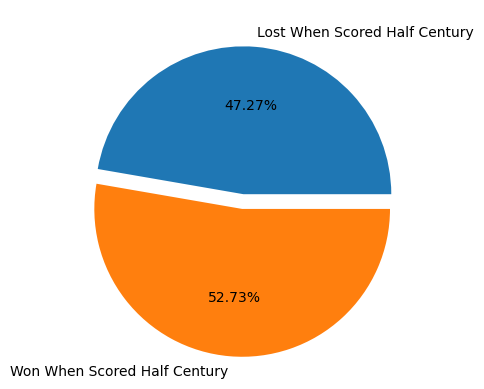

In [26]:
won_matches = century_win_cause('V Kohli', century = False)['Won'].sum()
lost_matches = century_win_cause('V Kohli', century = False).shape[0] - won_matches

plt.pie([lost_matches, won_matches],
        labels = ['Lost When Scored Half Century', 'Won When Scored Half Century'], 
        autopct = '%0.2f%%', explode = [0, 0.1])
plt.show()

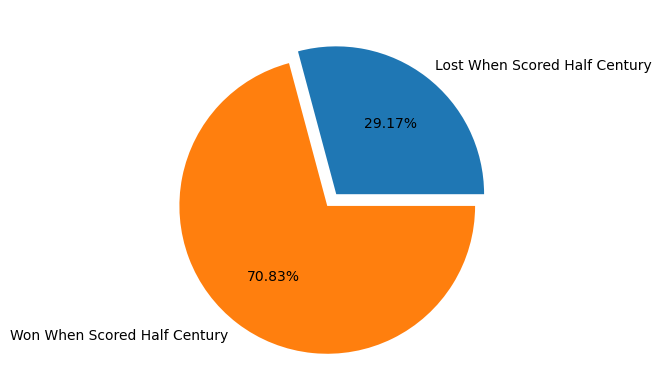

In [27]:
won_matches = century_win_cause('MS Dhoni', century = False)['Won'].sum()
lost_matches = century_win_cause('MS Dhoni', century = False).shape[0] - won_matches

plt.pie([lost_matches, won_matches],
        labels = ['Lost When Scored Half Century', 'Won When Scored Half Century'], 
        autopct = '%0.2f%%', explode = [0, 0.1])
plt.show()

In [28]:
century_win_cause('MS Dhoni', century = True)

,Batsman,Match ID,Season,Inning,Team,Bowling Team,Runs,Balls,Sixes,Fours,Threes,Twos,Ones,Dots,Century,Half_Century,Winner,Won


### 1.7. Top Scores by Players

In [29]:
def player_top_scores(player_name):
    return (
        match_runs(player_name)
        .sort_values(by = 'Runs', ascending = False, ignore_index = True)
    )

In [30]:
vkohli = player_top_scores('V Kohli')
vkohli

,Batsman,Match ID,Season,Inning,Team,Bowling Team,Runs,Balls,Sixes,Fours,Threes,Twos,Ones,Dots,Century,Half_Century
0,V Kohli,1422137,2024,1,Royal Challengers Bengaluru,Rajasthan Royals,113,77,4,12,0,5,31,25,1,0
1,V Kohli,980999,2016,1,Royal Challengers Bengaluru,Kings XI Punjab,113,51,8,12,0,2,13,16,1,0
2,V Kohli,980987,2016,1,Royal Challengers Bengaluru,Gujarat Titans,109,55,8,6,0,7,23,11,1,0
3,V Kohli,980969,2016,2,Royal Challengers Bengaluru,Rising Pune Supergiants,108,58,7,8,0,4,26,13,1,0
4,V Kohli,1359544,2023,1,Royal Challengers Bengaluru,Gujarat Titans,101,63,1,13,0,6,31,12,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,V Kohli,729287,2014,2,Royal Challengers Bengaluru,Mumbai Indians,0,2,0,0,0,0,0,2,0,0
240,V Kohli,733977,2014,2,Royal Challengers Bengaluru,Sunrisers Hyderabad,0,6,0,0,0,0,0,6,0,0
241,V Kohli,733991,2014,2,Royal Challengers Bengaluru,Kings XI Punjab,0,1,0,0,0,0,0,1,0,0
242,V Kohli,1304100,2022,1,Royal Challengers Bengaluru,Sunrisers Hyderabad,0,1,0,0,0,0,0,1,0,0


In [31]:
df = (
    match_runs('V Kohli')
    .groupby(by = ['Batsman', 'Bowling Team'], as_index = False)
    .agg(Runs = ('Runs', 'sum'), Innings = ('Match ID', 'nunique'))
)

### 1.8. Batsman Against Teams

In [32]:
def batsman_against_team(player_name, rival_team):
    return (
        match_runs(player_name)
        .query(f"`Bowling Team` == '{rival_team}'")
        .groupby(by = 'Bowling Team', as_index = False)
        .agg(
            Innings = ('Match ID', 'nunique'),
            Runs = ('Runs', 'sum'),
            Balls = ('Balls', 'sum'),
            Centuries = ('Century', 'sum'),
            Half_Centuries = ('Half_Century', 'sum'),
            Sixes = ('Sixes', 'sum'),
            Fours = ('Fours', 'sum'),
            Threes = ('Threes', 'sum'),
            Twos = ('Twos', 'sum'),
            Ones = ('Ones', 'sum'),
            Dots = ('Dots', 'sum'),
        )
        .merge(
            (
            df_all1.query(f"batter == '{player_name}' & bowling_team == '{rival_team}' & player_dismissed == '{player_name}'")
            .groupby(by = 'bowling_team', as_index = False)
            .agg(count = ('player_dismissed', 'count'))
            .rename(columns = {'bowling_team': 'Bowling Team', 'count': 'Dismissals'})
            ), on = 'Bowling Team', how = 'outer'
        )
        .assign(
            Strike_Rate = lambda df_: round((df_['Runs']/df_['Balls'])*100,4),
            Boundary_Percent = lambda df_: round(((df_['Sixes']*6 + df_['Fours']*4)/df_['Runs'])*100,4),
            Dot_Ball_Percent = lambda df_: round((df_['Dots']/df_['Balls'])*100,4),
            Not_Outs = lambda df_: df_['Innings'] - df_['Dismissals'],
            Batting_Average = lambda df_: round((df_['Runs']/df_['Dismissals']),4)
        )
        .rename(columns = {'Half_Centuries':'Half Centuries', 'Strike_Rate':'Strike Rate',
                           'Boundary_Percent':'Boundary Dominance', 'Dot_Ball_Percent': 'Dot Ball Reliance', 
                           'Not_Outs': 'Not Outs', 'Batting_Average': 'Batting Average'})
        [['Bowling Team', 'Innings', 'Runs', 'Balls', 'Centuries', 'Half Centuries', 'Sixes', 'Fours', 'Threes', 
              'Twos', 'Ones', 'Dots', 'Dismissals', 'Not Outs', 'Strike Rate', 'Batting Average', 'Boundary Dominance', 
              'Dot Ball Reliance']]
        
    )

In [33]:
batsman_against_team('AM Rahane', 'Kolkata Knight Riders')

,Bowling Team,Innings,Runs,Balls,Centuries,Half Centuries,Sixes,Fours,Threes,Twos,Ones,Dots,Dismissals,Not Outs,Strike Rate,Batting Average,Boundary Dominance,Dot Ball Reliance
0,Kolkata Knight Riders,22,565,450,0,3,18,54,2,28,179,169,19,3,125.5556,29.7368,57.3451,37.5556


## 2. Overall Bowler Stats

### 2.1. Player Team(s) for Seasons

In [34]:
def bowler_team(bowler_name):
    return (
        df_all1
        .groupby(by = ['bowler', 'bowling_team'], as_index = False)
        .agg(
            Season = ('season', lambda x: ", ".join(x.unique())),
            Count = ('season', 'nunique')
        )
        .query(f"bowler == '{bowler_name}'")
        .rename(columns = {'bowler': 'Bowler', 'bowling_team': 'Team'})
        .drop(columns = ['Bowler'])
    )
bowler_team('Z Khan')

,Team,Season,Count
955,Delhi Capitals,"2015, 2016, 2017",3
956,Mumbai Indians,"2009, 2010, 2014",3
957,Royal Challengers Bengaluru,"2008, 2011, 2012, 2013",4


### 2.2. Overall Stats

In [35]:
bowler_dismissal_type = ['bowled', 'lbw', 'stumped', 'caught and bowled', 'caught', 'hit wicket']
individual_wickets = (
    df_all1.query("is_wicket == 1 & dismissal_kind in @bowler_dismissal_type")
    .groupby(by = ['bowler', 'season', 'id', 'inning', 'bowling_team','batting_team'], as_index = False)
    .agg(
        matches = ('id', 'nunique'),
        wickets = ('is_wicket', 'sum')
    )
)

economy_rate = (
    df_all1
    .groupby(by = ['bowler', 'season', 'id', 'inning', 'bowling_team', 'batting_team'], as_index = False)
    .agg(
        balls = ('total_runs', 'count'),
        runs_conceded = ('total_runs', 'sum')
    )
    .assign(
        overs = lambda df_: round(df_['balls']/6, 2),
        economy_rate = lambda df_: round(df_['runs_conceded']/df_['overs'],2)
    )
    .sort_values(by = 'economy_rate', ascending = True, ignore_index = True)
)

dot_balls = (
    df_all1.query("total_runs == 0")
    .groupby(by = ['bowler', 'season', 'id', 'inning', 'bowling_team', 'batting_team'], as_index = False)
    .agg(
        dot_balls = ('total_runs', 'count')
    )
    .sort_values(by = 'dot_balls', ascending = False, ignore_index = True)
)

def runs_type_conceded(run_type, str_run_type):
    return (
        df_all1.query(f"batsman_runs == {run_type}")
        .groupby(by = ['bowler', 'season', 'id', 'inning', 'bowling_team', 'batting_team'], as_index=False)
        .agg(**{f'count_{str_run_type}_conceded': ('batsman_runs', 'count')}) 
    )

sixes_conceded_df = runs_type_conceded(run_type = 6, str_run_type = 'six')
fours_conceded_df = runs_type_conceded(run_type = 4, str_run_type = 'four')
threes_conceded_df = runs_type_conceded(run_type = 3, str_run_type = 'three')
twos_conceded_df = runs_type_conceded(run_type = 2, str_run_type = 'two')
ones_conceded_df = runs_type_conceded(run_type = 1, str_run_type = 'one')

bowler_extra_runs = (
    df_all1.query("extra_runs > 0")
    .groupby(by = ['bowler', 'season', 'id', 'inning', 'bowling_team', 'batting_team'], as_index = False)
    .agg(
        count_extra_runs = ('extra_runs', 'sum')
    )
)

bowler_stats_overall = (
    individual_wickets
    .merge(economy_rate, on = ['bowler', 'season', 'inning', 'id', 'bowling_team', 'batting_team'], how = 'outer')
    .merge(dot_balls, on = ['bowler', 'season', 'inning', 'id', 'bowling_team', 'batting_team'], how = 'outer')
    .merge(sixes_conceded_df, on = ['bowler', 'season', 'id', 'inning', 'bowling_team', 'batting_team'], how = 'outer')
    .merge(fours_conceded_df, on = ['bowler', 'season', 'id', 'inning', 'bowling_team', 'batting_team'], how = 'outer')
    .merge(threes_conceded_df, on = ['bowler', 'season', 'id', 'inning', 'bowling_team', 'batting_team'], how = 'outer')
    .merge(twos_conceded_df, on = ['bowler', 'season', 'id', 'inning', 'bowling_team', 'batting_team'], how = 'outer')
    .merge(ones_conceded_df, on = ['bowler', 'season', 'id', 'inning', 'bowling_team', 'batting_team'], how = 'outer')
    .merge(bowler_extra_runs, on = ['bowler', 'season', 'id', 'inning', 'bowling_team', 'batting_team'], how = 'outer')
    .assign(
        matches = lambda df_: df_['matches'].fillna(0).astype('int'),
        wickets = lambda df_: df_['wickets'].fillna(0).astype('int'),
        dot_balls = lambda df_: df_['dot_balls'].fillna(0).astype('int'),
        count_six_conceded = lambda df_: df_['count_six_conceded'].fillna(0).astype('int'),
        count_four_conceded = lambda df_: df_['count_four_conceded'].fillna(0).astype('int'),
        count_three_conceded = lambda df_: df_['count_three_conceded'].fillna(0).astype('int'),
        count_two_conceded = lambda df_: df_['count_two_conceded'].fillna(0).astype('int'),
        count_one_conceded = lambda df_: df_['count_one_conceded'].fillna(0).astype('int'),
        count_extra_runs = lambda df_: df_['count_extra_runs'].fillna(0).astype('int')
    )
    .assign(
        bowling_average = lambda df_: round(df_['runs_conceded']/df_['wickets'], 2),
        strike_rate = lambda df_: round(df_['balls']/df_['wickets'],2),
        boundary_rate = lambda df_: round((df_['count_six_conceded'] + df_['count_four_conceded'])/df_['balls'],2),
        dot_ball_percent = lambda df_: round((df_['dot_balls']/df_['balls'])*100, 4)
    )
)

In [36]:
bowler_stats_overall.head(2)

,bowler,season,id,inning,bowling_team,batting_team,matches,wickets,balls,runs_conceded,overs,economy_rate,dot_balls,count_six_conceded,count_four_conceded,count_three_conceded,count_two_conceded,count_one_conceded,count_extra_runs,bowling_average,strike_rate,boundary_rate,dot_ball_percent
0,A Ashish Reddy,2012,548329,2,Sunrisers Hyderabad,Delhi Capitals,0,0,12,29,2.0,14.5,3,2,3,0,1,3,0,inf,inf,0.42,25.0
1,A Ashish Reddy,2012,548341,2,Sunrisers Hyderabad,Rising Pune Supergiants,1,2,24,32,4.0,8.0,6,2,1,0,1,14,0,16.0,12.0,0.12,25.0


### 2.3. Bowler Stats Innings-wise

In [37]:
def bowler_stats_innings(bowler_name):
    return (
        bowler_stats_overall
        .groupby(by = ['bowler', 'inning'], as_index = False)
        .agg(
            matches = ('id', 'nunique'),
            wickets = ('wickets', 'sum'),
            balls = ('balls', 'sum'),
            runs_conceded = ('runs_conceded', 'sum'),
            dot_balls = ('dot_balls', 'sum'),
            count_six_conceded = ('count_six_conceded', 'sum'),
            count_four_conceded = ('count_four_conceded', 'sum'),
            count_three_conceded = ('count_three_conceded', 'sum'),
            count_two_conceded = ('count_two_conceded', 'sum'),
            count_one_conceded = ('count_one_conceded', 'sum'),
            count_extra_runs = ('count_extra_runs', 'sum')
        )
        .assign(
            overs = lambda df_: df_['balls']/6,
            bowling_average = lambda df_: round(df_['runs_conceded']/df_['wickets'], 4),
            strike_rate = lambda df_: round(df_['balls']/df_['wickets'], 4),
            boundary_rate = lambda df_: round((df_['count_six_conceded'] + df_['count_four_conceded'])*100/df_['balls'], 4),
            economy_rate = lambda df_: df_['runs_conceded']/df_['overs'],
            dot_ball_percent = lambda df_: round((df_['dot_balls']/df_['balls'])*100, 4)
        )
        .rename(columns = {'bowler': 'Bowler', 'inning': 'Inning', 'matches': 'Matches', 'wickets': 'Wickets',
                           'balls': 'Balls', 'overs': 'Overs', 'runs_conceded': 'Runs Conceded',
                           'economy_rate': 'Economy Rate', 'bowling_average': 'Bowling Average',
                           'strike_rate': 'Strike Rate', 'boundary_rate': 'Boundary Rate', 'dot_balls': 'Dot Balls', 
                           'dot_ball_percent': 'Dot Ball %', 'count_six_conceded': '6s Conceded', 
                           'count_four_conceded': '4s Conceded', 'count_three_conceded': '3s Conceded', 
                           'count_two_conceded': '2s Conceded', 'count_one_conceded': '1s Conceded', 
                           'count_extra_runs': 'Extra Runs'})
        .loc[:, ['Bowler', 'Inning', 'Matches', 'Wickets', 'Balls', 'Overs', 'Runs Conceded', 'Dot Balls',
                 'Economy Rate', 'Bowling Average', 'Strike Rate', 'Boundary Rate', 'Dot Ball %', '6s Conceded', 
                 '4s Conceded', '3s Conceded', '2s Conceded', '1s Conceded', 'Extra Runs']]
        .query(f"Bowler == '{bowler_name}'")
    )

In [38]:
bowler_stats_innings('Z Khan')

,Bowler,Inning,Matches,Wickets,Balls,Overs,Runs Conceded,Dot Balls,Economy Rate,Bowling Average,Strike Rate,Boundary Rate,Dot Ball %,6s Conceded,4s Conceded,3s Conceded,2s Conceded,1s Conceded,Extra Runs
961,Z Khan,1,51,50,1240,206.666667,1577,471,7.630645,31.5400,24.8000,16.5323,37.9839,36,169,4,82,410,94
962,Z Khan,2,48,52,1036,172.666667,1283,402,7.430502,24.6731,19.9231,16.5058,38.8031,28,143,5,60,333,75


### 2.4. Bowler Stats Season & Inning-wise

In [39]:
def bowler_stats_seasons_inning(bowler_name):
    return (
        bowler_stats_overall
        .groupby(by = ['bowler', 'season', 'inning'], as_index = False)
        .agg(
            matches = ('id', 'nunique'),
            wickets = ('wickets', 'sum'),
            balls = ('balls', 'sum'),
            runs_conceded = ('runs_conceded', 'sum'),
            dot_balls = ('dot_balls', 'sum'),
            count_six_conceded = ('count_six_conceded', 'sum'),
            count_four_conceded = ('count_four_conceded', 'sum'),
            count_three_conceded = ('count_three_conceded', 'sum'),
            count_two_conceded = ('count_two_conceded', 'sum'),
            count_one_conceded = ('count_one_conceded', 'sum'),
            count_extra_runs = ('count_extra_runs', 'sum')
        )
        .assign(
            overs = lambda df_: round(df_['balls']/6, 4),
            bowling_average = lambda df_: round(df_['runs_conceded']/df_['wickets'], 4),
            strike_rate = lambda df_: round(df_['balls']/df_['wickets'], 4),
            boundary_rate = lambda df_: round((df_['count_six_conceded'] + df_['count_four_conceded'])*100/df_['balls'], 4),
            economy_rate = lambda df_: round(df_['runs_conceded']/df_['overs'], 4),
            dot_ball_percent = lambda df_: round((df_['dot_balls']/df_['balls'])*100, 4)
        )
        .rename(columns = {'bowler': 'Bowler', 'season': 'Season', 'inning': 'Inning', 'matches': 'Matches', 'wickets': 'Wickets',
                           'balls': 'Balls', 'overs': 'Overs', 'runs_conceded': 'Runs Conceded',
                           'economy_rate': 'Economy Rate', 'bowling_average': 'Bowling Average',
                           'strike_rate': 'Strike Rate', 'boundary_rate': 'Boundary Rate', 'dot_balls': 'Dot Balls', 
                           'dot_ball_percent': 'Dot Ball %', 'count_six_conceded': '6s Conceded', 
                           'count_four_conceded': '4s Conceded', 'count_three_conceded': '3s Conceded', 
                           'count_two_conceded': '2s Conceded', 'count_one_conceded': '1s Conceded', 
                           'count_extra_runs': 'Extra Runs'})
        .loc[:, ['Bowler', 'Season', 'Inning', 'Matches', 'Wickets', 'Balls', 'Overs', 'Runs Conceded', 'Dot Balls',
                 'Economy Rate', 'Bowling Average', 'Strike Rate', 'Boundary Rate', 'Dot Ball %', '6s Conceded', 
                 '4s Conceded', '3s Conceded', '2s Conceded', '1s Conceded', 'Extra Runs']]
        .query(f"Bowler == '{bowler_name}'")
    )

In [40]:
bowler_stats_seasons_inning('JJ Bumrah')

,Bowler,Season,Inning,Matches,Wickets,Balls,Overs,Runs Conceded,Dot Balls,Economy Rate,Bowling Average,Strike Rate,Boundary Rate,Dot Ball %,6s Conceded,4s Conceded,3s Conceded,2s Conceded,1s Conceded,Extra Runs
1259,JJ Bumrah,2013,1,1,3,24,4.0000,36,11,9.0000,12.0000,8.0000,25.0000,45.8333,1,5,0,0,6,4
1260,JJ Bumrah,2013,2,1,0,21,3.5000,38,5,10.8571,inf,inf,28.5714,23.8095,1,5,0,2,5,3
1261,JJ Bumrah,2014,1,4,3,100,16.6667,110,42,6.6000,36.6667,33.3333,13.0000,42.0000,2,11,0,8,33,5
1262,JJ Bumrah,2014,2,7,2,146,24.3333,197,50,8.0959,98.5000,73.0000,18.4932,34.2466,6,21,0,8,51,10
1263,JJ Bumrah,2015,1,2,1,50,8.3333,107,8,12.8401,107.0000,50.0000,28.0000,16.0000,8,6,0,6,21,2
1264,JJ Bumrah,2015,2,2,2,48,8.0000,77,16,9.6250,38.5000,24.0000,22.9167,33.3333,5,6,0,2,13,6
1265,JJ Bumrah,2016,1,7,6,170,28.3333,235,55,8.2941,39.1667,28.3333,16.4706,32.3529,8,20,0,20,61,6
1266,JJ Bumrah,2016,2,7,9,152,25.3333,178,53,7.0263,19.7778,16.8889,11.8421,34.8684,5,13,0,14,57,11
1267,JJ Bumrah,2017,1,11,14,266,44.3333,342,87,7.7143,24.4286,19.0000,13.1579,32.7068,8,27,2,31,102,16
1268,JJ Bumrah,2017,2,5,6,99,16.5000,107,35,6.4848,17.8333,16.5000,10.1010,35.3535,1,9,2,7,42,3


### 2.5. Bowler Against Teams

In [41]:
def bowler_stats_teams(bowler_name):
    return (
        bowler_stats_overall
        .groupby(by = ['bowler', 'batting_team'], as_index = False)
        .agg(
            matches = ('id', 'nunique'),
            wickets = ('wickets', 'sum'),
            balls = ('balls', 'sum'),
            runs_conceded = ('runs_conceded', 'sum'),
            dot_balls = ('dot_balls', 'sum'),
            count_six_conceded = ('count_six_conceded', 'sum'),
            count_four_conceded = ('count_four_conceded', 'sum'),
            count_three_conceded = ('count_three_conceded', 'sum'),
            count_two_conceded = ('count_two_conceded', 'sum'),
            count_one_conceded = ('count_one_conceded', 'sum'),
            count_extra_runs = ('count_extra_runs', 'sum')
        )
        .assign(
            overs = lambda df_: df_['balls']/6,
            bowling_average = lambda df_: round(df_['runs_conceded']/df_['wickets'], 4),
            strike_rate = lambda df_: round(df_['balls']/df_['wickets'], 4),
            boundary_rate = lambda df_: round((df_['count_six_conceded'] + df_['count_four_conceded'])*100/df_['balls'], 4),
            economy_rate = lambda df_: df_['runs_conceded']/df_['overs'],
            dot_ball_percent = lambda df_: round((df_['dot_balls']/df_['balls'])*100, 4)
        )
        .rename(columns = {'bowler': 'Bowler', 'batting_team': 'Rival Team', 'matches': 'Matches', 'wickets': 'Wickets',
                           'balls': 'Balls', 'overs': 'Overs', 'runs_conceded': 'Runs Conceded',
                           'economy_rate': 'Economy Rate', 'bowling_average': 'Bowling Average',
                           'strike_rate': 'Strike Rate', 'boundary_rate': 'Boundary Rate', 'dot_balls': 'Dot Balls', 
                           'dot_ball_percent': 'Dot Ball %', 'count_six_conceded': '6s Conceded', 
                           'count_four_conceded': '4s Conceded', 'count_three_conceded': '3s Conceded', 
                           'count_two_conceded': '2s Conceded', 'count_one_conceded': '1s Conceded', 
                           'count_extra_runs': 'Extra Runs'})
        .loc[:, ['Bowler', 'Rival Team', 'Matches', 'Wickets', 'Balls', 'Overs', 'Runs Conceded', 'Dot Balls',
                 'Economy Rate', 'Bowling Average', 'Strike Rate', 'Boundary Rate', 'Dot Ball %', '6s Conceded', 
                 '4s Conceded', '3s Conceded', '2s Conceded', '1s Conceded', 'Extra Runs']]
        .query(f"Bowler == '{bowler_name}'")
    )

In [42]:
bowler_stats_teams('JJ Bumrah')

,Bowler,Rival Team,Matches,Wickets,Balls,Overs,Runs Conceded,Dot Balls,Economy Rate,Bowling Average,Strike Rate,Boundary Rate,Dot Ball %,6s Conceded,4s Conceded,3s Conceded,2s Conceded,1s Conceded,Extra Runs
1200,JJ Bumrah,Chennai Super Kings,15,12,364,60.666667,456,140,7.516484,38.0000,30.3333,15.1099,38.4615,15,40,1,29,113,32
1201,JJ Bumrah,Delhi Capitals,21,26,494,82.333333,603,182,7.323887,23.1923,19.0000,14.3725,36.8421,19,52,0,37,181,26
1202,JJ Bumrah,Gujarat Titans,6,8,152,25.333333,215,51,8.486842,26.8750,19.0000,19.0789,33.5526,5,24,0,14,50,11
1203,JJ Bumrah,Kings XI Punjab,16,23,377,62.833333,393,148,6.254642,17.0870,16.3913,10.3448,39.2573,7,32,0,27,141,28
1204,JJ Bumrah,Kolkata Knight Riders,18,25,411,68.500000,536,173,7.824818,21.4400,16.4400,17.0316,42.0925,22,48,0,26,127,33
1205,JJ Bumrah,Lucknow Super Giants,3,1,74,12.333333,73,33,5.918919,73.0000,74.0000,9.4595,44.5946,2,5,0,7,24,3
1206,JJ Bumrah,Rajasthan Royals,14,17,339,56.500000,360,150,6.371681,21.1765,19.9412,12.9794,44.2478,5,39,1,16,109,30
1207,JJ Bumrah,Rising Pune Supergiants,6,7,139,23.166667,180,46,7.769784,25.7143,19.8571,12.9496,33.0935,6,12,2,16,53,5
1208,JJ Bumrah,Royal Challengers Bengaluru,19,29,458,76.333333,576,174,7.545852,19.8621,15.7931,14.1921,37.9913,23,42,5,32,153,38
1209,JJ Bumrah,Sunrisers Hyderabad,15,17,353,58.833333,418,125,7.104816,24.5882,20.7647,13.3144,35.4108,7,40,3,22,146,17


### 2.6. Bowler against Team & Season-wise

In [43]:
def bowler_stats_teams_season(bowler_name, team):
    return (
        bowler_stats_overall
        .groupby(by = ['bowler', 'batting_team', 'season'], as_index = False)
        .agg(
            matches = ('id', 'nunique'),
            wickets = ('wickets', 'sum'),
            balls = ('balls', 'sum'),
            runs_conceded = ('runs_conceded', 'sum'),
            dot_balls = ('dot_balls', 'sum'),
            count_six_conceded = ('count_six_conceded', 'sum'),
            count_four_conceded = ('count_four_conceded', 'sum'),
            count_three_conceded = ('count_three_conceded', 'sum'),
            count_two_conceded = ('count_two_conceded', 'sum'),
            count_one_conceded = ('count_one_conceded', 'sum'),
            count_extra_runs = ('count_extra_runs', 'sum')
        )
        .assign(
            overs = lambda df_: df_['balls']/6,
            bowling_average = lambda df_: round(df_['runs_conceded']/df_['wickets'], 4),
            strike_rate = lambda df_: round(df_['balls']/df_['wickets'], 4),
            boundary_rate = lambda df_: round((df_['count_six_conceded'] + df_['count_four_conceded'])*100/df_['balls'], 4),
            economy_rate = lambda df_: df_['runs_conceded']/df_['overs'],
            dot_ball_percent = lambda df_: round((df_['dot_balls']/df_['balls'])*100, 4)
        )
        .rename(columns = {'bowler': 'Bowler', 'season': 'Season', 'batting_team': 'Rival Team', 'matches': 'Matches', 'wickets': 'Wickets',
                           'balls': 'Balls', 'overs': 'Overs', 'runs_conceded': 'Runs Conceded',
                           'economy_rate': 'Economy Rate', 'bowling_average': 'Bowling Average',
                           'strike_rate': 'Strike Rate', 'boundary_rate': 'Boundary Rate', 'dot_balls': 'Dot Balls', 
                           'dot_ball_percent': 'Dot Ball %', 'count_six_conceded': '6s Conceded', 
                           'count_four_conceded': '4s Conceded', 'count_three_conceded': '3s Conceded', 
                           'count_two_conceded': '2s Conceded', 'count_one_conceded': '1s Conceded', 
                           'count_extra_runs': 'Extra Runs'})
        .loc[:, ['Bowler', 'Rival Team', 'Season', 'Matches', 'Wickets', 'Balls', 'Overs', 'Runs Conceded', 'Dot Balls',
                 'Economy Rate', 'Bowling Average', 'Strike Rate', 'Boundary Rate', 'Dot Ball %', '6s Conceded', 
                 '4s Conceded', '3s Conceded', '2s Conceded', '1s Conceded', 'Extra Runs']]
        .query(f"Bowler == '{bowler_name}' & `Rival Team` == '{team}'")
    )

In [44]:
bowler_stats_teams_season('JJ Bumrah', 'Chennai Super Kings').query(f"Season == '{2014}'")

,Bowler,Rival Team,Season,Matches,Wickets,Balls,Overs,Runs Conceded,Dot Balls,Economy Rate,Bowling Average,Strike Rate,Boundary Rate,Dot Ball %,6s Conceded,4s Conceded,3s Conceded,2s Conceded,1s Conceded,Extra Runs
3158,JJ Bumrah,Chennai Super Kings,2014,2,0,48,8.0,75,15,9.375,inf,inf,25.0,31.25,1,11,0,4,13,4
